mkdir -p failed for path /home/jovyan/.cache/matplotlib: [Errno 13] Permission denied: '/home/jovyan/.cache/matplotlib'
Matplotlib created a temporary cache directory at /tmp/matplotlib-z0098m23 because there was an issue with the default path (/home/jovyan/.cache/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
2025-08-16 15:52:14.051647: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-16 15:52:14.072937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-16 15:52:14.213395: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your ma

Epoch 0 finished.
Epoch 10 finished.
Epoch 20 finished.
Epoch 30 finished.
Epoch 40 finished.
7/7 [==============================] - 0s 3ms/step


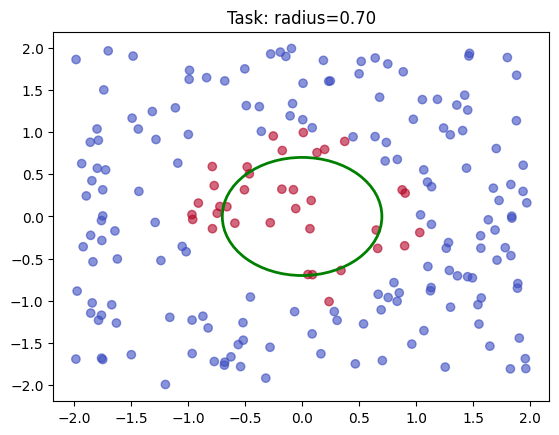

7/7 [==============================] - 0s 4ms/step


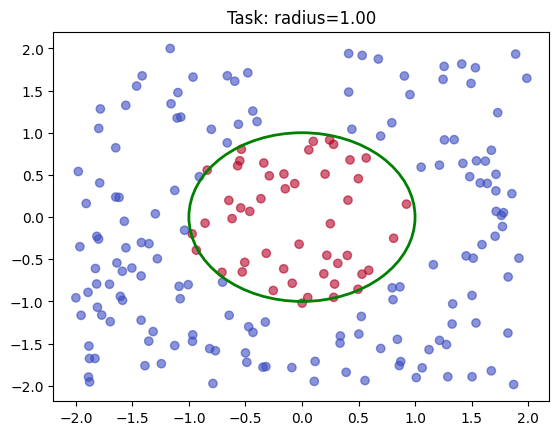

7/7 [==============================] - 0s 3ms/step


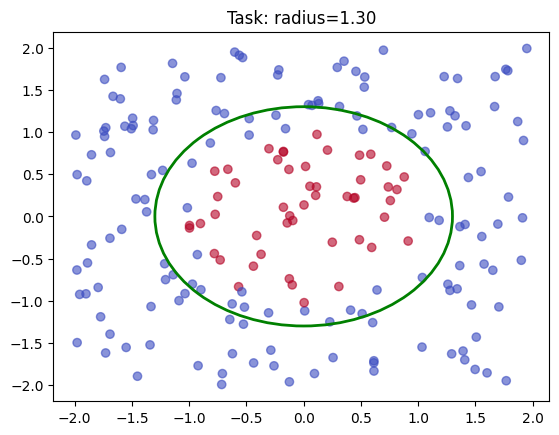

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# -------------------------
# 生成任务 (不同半径的圆形分类)
# -------------------------
def generate_task(n_samples=100, radius=1.0):
    X = np.random.uniform(-2, 2, (n_samples, 2))
    y = (np.linalg.norm(X, axis=1) < radius).astype(np.int32)
    y = tf.keras.utils.to_categorical(y, num_classes=2)
    return X.astype(np.float32), y.astype(np.float32)

# -------------------------
# 创建简单的分类器 (MLP)
# -------------------------
def create_model():
    model = models.Sequential([
        layers.Dense(40, activation="relu", input_shape=(2,)),
        layers.Dense(40, activation="relu"),
        layers.Dense(2, activation="softmax")
    ])
    return model

# -------------------------
# MAML: Inner Update
# -------------------------
def inner_update(model, X_support, y_support, lr_inner=0.1):
    with tf.GradientTape() as tape:
        preds = model(X_support, training=True)
        loss = tf.keras.losses.categorical_crossentropy(y_support, preds)
        loss = tf.reduce_mean(loss)
    grads = tape.gradient(loss, model.trainable_variables)
    updated_vars = [w - lr_inner*g for w, g in zip(model.trainable_variables, grads)]
    return updated_vars

# -------------------------
# MAML: Outer Update
# -------------------------
meta_model = create_model()
meta_optimizer = tf.keras.optimizers.Adam(0.01)

def outer_update(num_tasks=5):
    meta_grads = [tf.zeros_like(var) for var in meta_model.trainable_variables]

    for _ in range(num_tasks):
        radius = np.random.uniform(0.5, 1.5)  # 每个任务不同的圆
        X, y = generate_task(100, radius)
        X_support, y_support = X[:20], y[:20]  # few-shot support
        X_query, y_query = X[20:], y[20:]      # query

        # 内层更新
        updated_vars = inner_update(meta_model, X_support, y_support)

        # 在 query set 上计算损失
        with tf.GradientTape() as tape:
            preds = meta_model(X_query, training=True)
            loss = tf.keras.losses.categorical_crossentropy(y_query, preds)
            loss = tf.reduce_mean(loss)
        grads = tape.gradient(loss, meta_model.trainable_variables)
        meta_grads = [mg + g for mg, g in zip(meta_grads, grads)]

    # 更新 meta-parameters
    meta_grads = [mg / num_tasks for mg in meta_grads]
    meta_optimizer.apply_gradients(zip(meta_grads, meta_model.trainable_variables))

# -------------------------
# 训练 MAML
# -------------------------
for epoch in range(50):
    outer_update()
    if epoch % 10 == 0:
        print(f"Epoch {epoch} finished.")

# -------------------------
# 可视化效果
# -------------------------
def plot_task(model, radius):
    X, y = generate_task(200, radius)
    preds = model.predict(X)
    pred_labels = np.argmax(preds, axis=1)

    plt.scatter(X[:,0], X[:,1], c=pred_labels, cmap="coolwarm", alpha=0.6)
    circle = plt.Circle((0,0), radius, color='green', fill=False, linewidth=2)
    plt.gca().add_artist(circle)
    plt.title(f"Task: radius={radius:.2f}")
    plt.show()

# 测试不同任务上的泛化
for r in [0.7, 1.0, 1.3]:
    plot_task(meta_model, r)


In [3]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# =============================
# 超参数
# =============================
DATA_GLOB = "./data/*.csv"         # CSV: 每行 [feat1,...,featK,label]；无标签用 -1
SEQ_LEN = 64
FEATURE_DIM = 64                   # 编码器输出维度
BATCH_SIZE = 32

EPOCHS_CONTRASTIVE = 10            # 对比学习预训练轮数（无标签）
EPOCHS_META = 30                   # 元学习轮数（有标签）
INNER_STEPS = 1                    # 任务内微调步数
INNER_LR = 1e-2                    # 任务内学习率
META_LR = 1e-3                     # 元更新学习率
REPTILE_EPS = 0.1                  # Reptile 步长（meta 权重向 task 权重靠拢的比例）

NUM_CLASSES = 3

np.random.seed(42)
tf.random.set_seed(42)

# =============================
# 1) 加载 CSV -> 滑窗样本 + 记录每个窗口的 task_id
#    约定：每个 CSV 代表一个“任务域”（不同植物/环境），便于元学习抽 task
# =============================
X_labeled_list, y_labeled_list, task_id_list = [], [], []
X_unlabeled_list = []

csv_files = sorted(glob.glob(DATA_GLOB))
if len(csv_files) == 0:
    raise FileNotFoundError(f"未找到数据：{DATA_GLOB}")

for tid, file in enumerate(csv_files):
    df = pd.read_csv(file).fillna(-1)  # NaN -> -1 表示无标签
    data = df.values.astype(np.float32)
    feats = data[:, :-1]
    labels = data[:, -1]

    # 构建滑窗
    for i in range(len(data) - SEQ_LEN + 1):
        window_x = feats[i:i+SEQ_LEN]
        window_y = labels[i+SEQ_LEN-1]  # 用窗口末尾的标签
        if window_y == -1:
            X_unlabeled_list.append(window_x)
        else:
            X_labeled_list.append(window_x)
            y_labeled_list.append(int(window_y))
            task_id_list.append(tid)  # 该窗口从哪个 CSV 来

X_unlabeled = np.array(X_unlabeled_list, dtype=np.float32)
if len(X_labeled_list) > 0:
    X_labeled = np.array(X_labeled_list, dtype=np.float32)
    y_labeled = np.array(y_labeled_list, dtype=np.int32)
    task_ids   = np.array(task_id_list,  dtype=np.int32)
    print("有标签样本:", X_labeled.shape, "任务域数:", len(csv_files))
else:
    X_labeled = np.empty((0, SEQ_LEN, X_unlabeled.shape[-1] if len(X_unlabeled)>0 else 3), dtype=np.float32)
    y_labeled = np.empty((0,), dtype=np.int32)
    task_ids  = np.empty((0,), dtype=np.int32)
    print("警告：没有有标签样本，后续仅能做无监督预训练和导出编码器。")

NUM_FEATS = (X_labeled.shape[2] if X_labeled.size>0 else
             (X_unlabeled.shape[2] if X_unlabeled.size>0 else 3))

# =============================
# 2) 对比学习（SimCLR 风格）预训练 LSTM 编码器
# =============================
def augment_window(x):
    # 轻微高斯噪声 + 随机时序丢帧/抖动（简化版）
    x = x + np.random.normal(0, 0.01, x.shape).astype(np.float32)
    return x

def make_contrastive_pairs(X):
    anchors, positives = [], []
    for w in X:
        anchors.append(w)
        positives.append(augment_window(w))
    return np.stack(anchors).astype(np.float32), np.stack(positives).astype(np.float32)

class NTXentLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def call(self, z_i, z_j):
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)
        logits = tf.matmul(z_i, z_j, transpose_b=True) / self.temperature
        labels = tf.range(tf.shape(z_i)[0])
        loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_j = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)
        return tf.reduce_mean(loss_i + loss_j)

def build_lstm_encoder(seq_len, num_feats, feature_dim=FEATURE_DIM):
    inp = layers.Input(shape=(seq_len, num_feats))
    x = layers.LSTM(feature_dim, return_sequences=False)(inp)
    out = layers.Dense(feature_dim, activation="relu")(x)
    return models.Model(inp, out, name="lstm_encoder")

lstm_encoder = build_lstm_encoder(SEQ_LEN, NUM_FEATS, FEATURE_DIM)
contrastive_opt = tf.keras.optimizers.Adam()

# 若无无标签数据，生成一些随机窗口做预训练
if X_unlabeled.size == 0:
    print("没有无标签数据，生成随机数据用于对比学习预训练……")
    X_unlabeled = np.random.randn(200, SEQ_LEN, NUM_FEATS).astype(np.float32)

anchors, positives = make_contrastive_pairs(X_unlabeled)
contrast_ds = tf.data.Dataset.from_tensor_slices((anchors, positives)).shuffle(2048).batch(BATCH_SIZE)

ntxent = NTXentLoss(temperature=0.2)
for ep in range(EPOCHS_CONTRASTIVE):
    for a, p in contrast_ds:
        with tf.GradientTape() as tape:
            za = lstm_encoder(a, training=True)
            zp = lstm_encoder(p, training=True)
            loss = ntxent(za, zp)
        grads = tape.gradient(loss, lstm_encoder.trainable_variables)
        contrastive_opt.apply_gradients(zip(grads, lstm_encoder.trainable_variables))
    print(f"[Contrastive] Epoch {ep+1}/{EPOCHS_CONTRASTIVE} loss={float(loss.numpy()):.4f}")

# =============================
# 3) 元学习（Reptile）
#    思想：对每个任务，复制模型 -> 在 support 上做若干步微调
#          将 meta 权重朝“任务后权重”移动（平均多个任务）
# =============================
def build_meta_model(encoder, num_classes=NUM_CLASSES):
    # 复制一个具有相同结构的编码器 + 分类头
    inp = layers.Input(shape=(SEQ_LEN, NUM_FEATS))
    x = encoder(inp)  # 使用已有编码器作为 backbone
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="meta_lstm_classifier")

meta_model = build_meta_model(lstm_encoder, NUM_CLASSES)
meta_optimizer = tf.keras.optimizers.Adam(META_LR)

# 将有标签数据按 task_id 聚合，便于采样任务
task_to_indices = {}
for idx, tid in enumerate(task_ids):
    task_to_indices.setdefault(int(tid), []).append(idx)
task_ids_unique = list(task_to_indices.keys())

def sample_task_batches(X, y, idx_list, batch_size):
    """ 从某任务的样本索引集合中，采一个 batch（用于 support/query） """
    idx = np.random.choice(idx_list, size=min(batch_size, len(idx_list)), replace=False)
    return X[idx], y[idx]

def clone_weights(model):
    return [w.numpy().copy() for w in model.get_weights()]

def assign_weights(model, weights_list):
    model.set_weights(weights_list)

def reptile_meta_step(meta_model, task_ids_unique, inner_steps=INNER_STEPS,
                      inner_lr=INNER_LR, reptile_eps=REPTILE_EPS,
                      support_bs=32, query_bs=64):
    """
    执行一次 Reptile 外层更新：
      1) 采样若干任务
      2) 对每个任务：克隆模型 -> 在 support 上做 inner_steps 次 SGD
      3) 收集任务后权重，meta 权重朝其平均值移动
    """
    if len(task_ids_unique) == 0:
        return  # 没有有标签任务可用

    # 保存 meta 初始权重
    meta_w = clone_weights(meta_model)
    task_weights = []

    for tid in task_ids_unique:
        idx_list = task_to_indices[tid]
        # 克隆一个任务模型（结构相同，复制 meta 当前权重）
        task_model = build_meta_model(lstm_encoder, NUM_CLASSES)
        assign_weights(task_model, meta_w)
        # 任务内优化器（独立于 meta_optimizer）
        inner_opt = tf.keras.optimizers.SGD(learning_rate=inner_lr)

        # inner loop：在该任务的 support 上做若干步
        for _ in range(inner_steps):
            Xs, ys = sample_task_batches(X_labeled, y_labeled, idx_list, support_bs)
            with tf.GradientTape() as tape:
                preds = task_model(Xs, training=True)
                loss = tf.keras.losses.sparse_categorical_crossentropy(ys, preds)
                loss = tf.reduce_mean(loss)
            grads = tape.gradient(loss, task_model.trainable_variables)
            inner_opt.apply_gradients(zip(grads, task_model.trainable_variables))

        # （可选）在 query 上评估一下
        Xq, yq = sample_task_batches(X_labeled, y_labeled, idx_list, query_bs)
        q_preds = task_model(Xq, training=False)
        q_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(q_preds, axis=1), yq), tf.float32))
        print(f"  Task {tid}: query_acc={float(q_acc.numpy()):.3f}")

        # 收集该任务训练后的权重
        task_weights.append(clone_weights(task_model))

    # 将 meta 权重朝各任务权重的平均值靠拢（Reptile 更新）
    avg_task_w = []
    for weights_per_layer in zip(*task_weights):
        avg_task_w.append(np.mean(np.stack(weights_per_layer, axis=0), axis=0))

    # new_meta = meta + eps * (avg_task - meta)
    new_meta_w = [mw + reptile_eps * (aw - mw) for mw, aw in zip(meta_w, avg_task_w)]
    assign_weights(meta_model, new_meta_w)

# ======= 元训练循环 =======
if X_labeled.size > 0:
    for ep in range(EPOCHS_META):
        print(f"[Meta] Epoch {ep+1}/{EPOCHS_META}")
        reptile_meta_step(meta_model, task_ids_unique,
                          inner_steps=INNER_STEPS, inner_lr=INNER_LR,
                          reptile_eps=REPTILE_EPS, support_bs=BATCH_SIZE, query_bs=BATCH_SIZE*2)
else:
    print("跳过元学习：没有有标签数据。")

# =============================
# 4) 可选：在整体验证集上做一个快速评估（把所有有标签样本打乱切分）
# =============================
if X_labeled.size > 0:
    perm = np.random.permutation(len(X_labeled))
    split = int(0.8 * len(perm))
    tr_idx, va_idx = perm[:split], perm[split:]
    Xtr, ytr = X_labeled[tr_idx], y_labeled[tr_idx]
    Xva, yva = X_labeled[va_idx], y_labeled[va_idx]

    # 仅微调最后分类头（模拟 few-shot 适应场景）
    meta_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy"])
    hist = meta_model.fit(Xtr, ytr, validation_data=(Xva, yva),
                          epochs=5, batch_size=BATCH_SIZE, verbose=1)
    print("Val acc (after short finetune):", hist.history["val_accuracy"][-1])

# =============================
# 5) 导出 TFLite：编码器 + 元分类器
# =============================
def save_tflite(model, out_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False
    tflite_model = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite:", out_path)

# 独立导出编码器（用于边端只提特征）
save_tflite(lstm_encoder, "lstm_encoder_contrastive.tflite")
# 导出元学习后的端到端分类器（编码器 + 分类头）
if X_labeled.size > 0:
    save_tflite(meta_model, "meta_lstm_classifier.tflite")


有标签样本: (21850, 64, 3) 任务域数: 50
没有无标签数据，生成随机数据用于对比学习预训练……
[Contrastive] Epoch 1/10 loss=0.5915
[Contrastive] Epoch 2/10 loss=1.0623
[Contrastive] Epoch 3/10 loss=0.4280
[Contrastive] Epoch 4/10 loss=0.2765
[Contrastive] Epoch 5/10 loss=0.1987
[Contrastive] Epoch 6/10 loss=0.2600
[Contrastive] Epoch 7/10 loss=0.2907
[Contrastive] Epoch 8/10 loss=0.6317
[Contrastive] Epoch 9/10 loss=0.2446
[Contrastive] Epoch 10/10 loss=0.2411
[Meta] Epoch 1/30


AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [5]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models

# =============================
# 超参数
# =============================
DATA_GLOB = "./data/*.csv"      # CSV: 每行 [feat1,...,featK,label]；无标签用 -1
SEQ_LEN = 64
FEATURE_DIM = 64                # LSTM 编码器输出
BATCH_SIZE = 32
EPOCHS_CONTRASTIVE = 10         # 对比学习轮数
EPOCHS_META = 30                # FOMAML 元学习轮数
INNER_STEPS = 1                 # 内层微调步数
INNER_LR = 1e-2
META_LR = 1e-3
NUM_CLASSES = 3

np.random.seed(42)
tf.random.set_seed(42)

# =============================
# 1) 加载 CSV -> 滑窗样本
# =============================
X_labeled_list, y_labeled_list = [], []
X_unlabeled_list = []

csv_files = sorted(glob.glob(DATA_GLOB))
if len(csv_files) == 0:
    raise FileNotFoundError(f"未找到数据：{DATA_GLOB}")

for file in csv_files:
    df = pd.read_csv(file).fillna(-1)
    data = df.values.astype(np.float32)
    feats = data[:, :-1]
    labels = data[:, -1]

    for i in range(len(data) - SEQ_LEN + 1):
        window_x = feats[i:i+SEQ_LEN]
        window_y = labels[i+SEQ_LEN-1]
        if window_y == -1:
            X_unlabeled_list.append(window_x)
        else:
            X_labeled_list.append(window_x)
            y_labeled_list.append(int(window_y))

X_unlabeled = np.array(X_unlabeled_list, dtype=np.float32)
if len(X_labeled_list) > 0:
    X_labeled = np.array(X_labeled_list, dtype=np.float32)
    y_labeled = np.array(y_labeled_list, dtype=np.int32)
    print("有标签样本:", X_labeled.shape)
else:
    X_labeled = np.empty((0, SEQ_LEN, X_unlabeled.shape[2] if X_unlabeled.size>0 else 3), dtype=np.float32)
    y_labeled = np.empty((0,), dtype=np.int32)
    print("警告：没有有标签样本，仅能做无监督预训练")

NUM_FEATS = X_labeled.shape[2] if X_labeled.size>0 else (X_unlabeled.shape[2] if X_unlabeled.size>0 else 3)

# =============================
# 2) 对比学习 (SimCLR)
# =============================
def augment_window(x):
    return x + np.random.normal(0, 0.01, x.shape).astype(np.float32)

def make_contrastive_pairs(X):
    anchors, positives = [], []
    for w in X:
        anchors.append(w)
        positives.append(augment_window(w))
    return np.stack(anchors).astype(np.float32), np.stack(positives).astype(np.float32)

class NTXentLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
    def call(self, z_i, z_j):
        z_i = tf.math.l2_normalize(z_i, axis=1)
        z_j = tf.math.l2_normalize(z_j, axis=1)
        logits = tf.matmul(z_i, z_j, transpose_b=True) / self.temperature
        labels = tf.range(tf.shape(z_i)[0])
        loss_i = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
        loss_j = tf.keras.losses.sparse_categorical_crossentropy(labels, tf.transpose(logits), from_logits=True)
        return tf.reduce_mean(loss_i + loss_j)

def build_lstm_encoder(seq_len, num_feats, feature_dim=FEATURE_DIM):
    inp = layers.Input(shape=(seq_len, num_feats))
    x = layers.LSTM(feature_dim, return_sequences=False)(inp)
    out = layers.Dense(feature_dim, activation="relu")(x)
    return models.Model(inp, out, name="lstm_encoder")

lstm_encoder = build_lstm_encoder(SEQ_LEN, NUM_FEATS, FEATURE_DIM)
contrastive_opt = tf.keras.optimizers.Adam()

if X_unlabeled.size == 0:
    X_unlabeled = np.random.randn(200, SEQ_LEN, NUM_FEATS).astype(np.float32)

anchors, positives = make_contrastive_pairs(X_unlabeled)
contrast_ds = tf.data.Dataset.from_tensor_slices((anchors, positives)).shuffle(2048).batch(BATCH_SIZE)

ntxent = NTXentLoss(temperature=0.2)
for ep in range(EPOCHS_CONTRASTIVE):
    for a, p in contrast_ds:
        with tf.GradientTape() as tape:
            za = lstm_encoder(a, training=True)
            zp = lstm_encoder(p, training=True)
            loss = ntxent(za, zp)
        grads = tape.gradient(loss, lstm_encoder.trainable_variables)
        contrastive_opt.apply_gradients(zip(grads, lstm_encoder.trainable_variables))
    print(f"[Contrastive] Epoch {ep+1}/{EPOCHS_CONTRASTIVE}, loss={float(loss.numpy()):.4f}")

# =============================
# 3) FOMAML 元学习
# =============================
def build_meta_model(encoder, num_classes=NUM_CLASSES):
    inp = layers.Input(shape=(SEQ_LEN, NUM_FEATS))
    x = encoder(inp)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(num_classes, activation="softmax")(x)
    return models.Model(inp, out, name="meta_lstm_classifier")

meta_model = build_meta_model(lstm_encoder, NUM_CLASSES)
meta_optimizer = tf.keras.optimizers.Adam(META_LR)

# 生成支持/查询任务
def sample_tasks(X, y, num_tasks=5, support_size=10, query_size=20):
    tasks = []
    for _ in range(num_tasks):
        idx = np.random.choice(len(X), support_size+query_size, replace=False)
        X_support, y_support = X[idx[:support_size]], y[idx[:support_size]]
        X_query, y_query = X[idx[support_size:]], y[idx[support_size:]]
        tasks.append((X_support, y_support, X_query, y_query))
    return tasks

# FOMAML 外层更新
def outer_update_fomaml(meta_model, meta_optimizer, tasks, lr_inner=INNER_LR):
    meta_grads = [tf.zeros_like(var) for var in meta_model.trainable_variables]
    for X_support, y_support, X_query, y_query in tasks:
        original_weights = [w.numpy() for w in meta_model.trainable_variables]
        # inner update
        with tf.GradientTape() as tape_inner:
            preds_support = meta_model(X_support, training=True)
            loss_support = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_support, preds_support))
        grads_inner = tape_inner.gradient(loss_support, meta_model.trainable_variables)
        temp_vars = [w - lr_inner*g for w,g in zip(meta_model.trainable_variables, grads_inner)]
        # query 上求梯度
        with tf.GradientTape() as tape:
            for var, temp in zip(meta_model.trainable_variables, temp_vars):
                var.assign(temp)
            preds_query = meta_model(X_query, training=True)
            loss_query = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_query, preds_query))
        grads = tape.gradient(loss_query, meta_model.trainable_variables)
        meta_grads = [mg + g for mg, g in zip(meta_grads, grads)]
        # 恢复 meta 参数
        for var, orig in zip(meta_model.trainable_variables, original_weights):
            var.assign(orig)
    meta_grads = [mg / len(tasks) for mg in meta_grads]
    meta_optimizer.apply_gradients(zip(meta_grads, meta_model.trainable_variables))

# =============================
# 元训练循环
# =============================
if X_labeled.size > 0:
    for ep in range(EPOCHS_META):
        tasks = sample_tasks(X_labeled, y_labeled, num_tasks=5)
        outer_update_fomaml(meta_model, meta_optimizer, tasks)
        print(f"[Meta] Epoch {ep+1}/{EPOCHS_META} finished.")
else:
    print("跳过元学习：没有有标签数据。")

# =============================
# 4) 导出 TFLite
# =============================
def save_tflite(model, out_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    tflite_model = converter.convert()
    with open(out_path, "wb") as f:
        f.write(tflite_model)
    print("Saved TFLite:", out_path)

save_tflite(lstm_encoder, "lstm_encoder_contrastive.tflite")
if X_labeled.size > 0:
    save_tflite(meta_model, "meta_lstm_classifier.tflite")


有标签样本: (21850, 64, 3)
[Contrastive] Epoch 1/10, loss=0.7586
[Contrastive] Epoch 2/10, loss=1.0667
[Contrastive] Epoch 3/10, loss=0.4718
[Contrastive] Epoch 4/10, loss=0.2666
[Contrastive] Epoch 5/10, loss=0.1443
[Contrastive] Epoch 6/10, loss=0.6434
[Contrastive] Epoch 7/10, loss=0.6282
[Contrastive] Epoch 8/10, loss=1.1109
[Contrastive] Epoch 9/10, loss=0.1931
[Contrastive] Epoch 10/10, loss=0.2693
[Meta] Epoch 1/30 finished.
[Meta] Epoch 2/30 finished.
[Meta] Epoch 3/30 finished.
[Meta] Epoch 4/30 finished.
[Meta] Epoch 5/30 finished.
[Meta] Epoch 6/30 finished.
[Meta] Epoch 7/30 finished.
[Meta] Epoch 8/30 finished.
[Meta] Epoch 9/30 finished.
[Meta] Epoch 10/30 finished.
[Meta] Epoch 11/30 finished.
[Meta] Epoch 12/30 finished.
[Meta] Epoch 13/30 finished.
[Meta] Epoch 14/30 finished.
[Meta] Epoch 15/30 finished.
[Meta] Epoch 16/30 finished.
[Meta] Epoch 17/30 finished.
[Meta] Epoch 18/30 finished.
[Meta] Epoch 19/30 finished.
[Meta] Epoch 20/30 finished.
[Meta] Epoch 21/30 finishe

INFO:tensorflow:Assets written to: /tmp/tmpie508p4v/assets
2025-08-16 16:15:28.101700: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-16 16:15:28.101749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-16 16:15:28.102394: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpie508p4v
2025-08-16 16:15:28.106452: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-16 16:15:28.106468: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpie508p4v
2025-08-16 16:15:28.122013: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-08-16 16:15:28.124764: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-16 16:15:28.161807: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

Saved TFLite: lstm_encoder_contrastive.tflite
INFO:tensorflow:Assets written to: /tmp/tmpcseotsga/assets


INFO:tensorflow:Assets written to: /tmp/tmpcseotsga/assets


Saved TFLite: meta_lstm_classifier.tflite


2025-08-16 16:15:31.264266: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-16 16:15:31.264319: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-16 16:15:31.264484: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcseotsga
2025-08-16 16:15:31.268265: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-16 16:15:31.268285: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpcseotsga
2025-08-16 16:15:31.285596: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-16 16:15:31.324842: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpcseotsga
2025-08-16 16:15:31.351117: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 86632 m

[Contrastive] Epoch 1/10, loss=0.5716
[Contrastive] Epoch 2/10, loss=0.6983
[Contrastive] Epoch 3/10, loss=0.3911
[Contrastive] Epoch 4/10, loss=0.2089
[Contrastive] Epoch 5/10, loss=0.1724
[Contrastive] Epoch 6/10, loss=0.3056
[Contrastive] Epoch 7/10, loss=0.6288
[Contrastive] Epoch 8/10, loss=0.4035
[Contrastive] Epoch 9/10, loss=0.2004
[Contrastive] Epoch 10/10, loss=0.4399
[Meta] Epoch 1/20, query_loss=1.0021, query_acc=0.5500
[Meta] Epoch 2/20, query_loss=1.0772, query_acc=0.4500
[Meta] Epoch 3/20, query_loss=0.9999, query_acc=0.4500
[Meta] Epoch 4/20, query_loss=0.9923, query_acc=0.3500
[Meta] Epoch 5/20, query_loss=0.9411, query_acc=0.4500
[Meta] Epoch 6/20, query_loss=0.9352, query_acc=0.3500
[Meta] Epoch 7/20, query_loss=0.8386, query_acc=0.7500
[Meta] Epoch 8/20, query_loss=0.8666, query_acc=0.5000
[Meta] Epoch 9/20, query_loss=0.8641, query_acc=0.3500
[Meta] Epoch 10/20, query_loss=0.8331, query_acc=0.6000
[Meta] Epoch 11/20, query_loss=0.8468, query_acc=0.2500
[Meta] Epoch

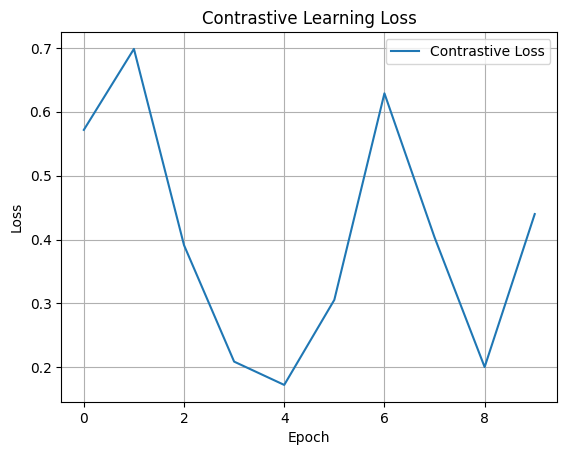

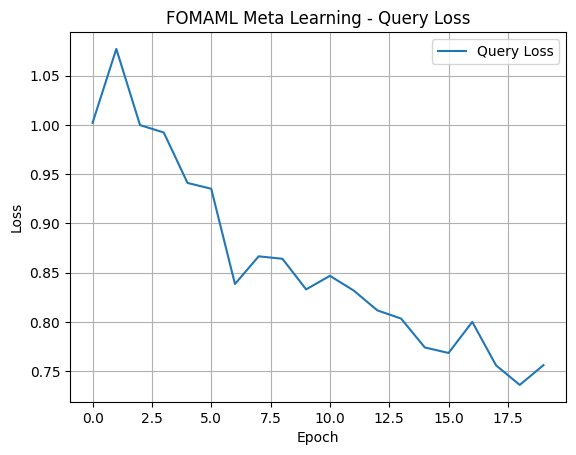

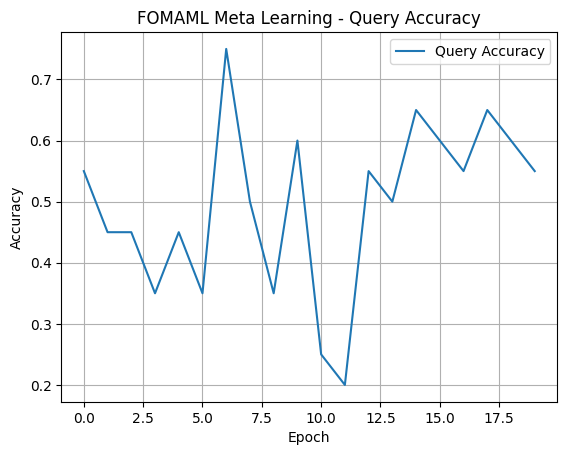

INFO:tensorflow:Assets written to: /tmp/tmp8us5suak/assets


INFO:tensorflow:Assets written to: /tmp/tmp8us5suak/assets
2025-08-16 16:26:09.196341: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-16 16:26:09.196448: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-16 16:26:09.196792: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8us5suak
2025-08-16 16:26:09.207883: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-16 16:26:09.207944: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp8us5suak
2025-08-16 16:26:09.248537: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-16 16:26:09.331717: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmp8us5suak
2025-08-16 16:26:09.392111: I tensorflow/cc/saved_model/loader.cc:314] SavedModel

Saved TFLite: lstm_encoder_contrastive.tflite
INFO:tensorflow:Assets written to: /tmp/tmpw9vjpnh5/assets


INFO:tensorflow:Assets written to: /tmp/tmpw9vjpnh5/assets


Saved TFLite: meta_lstm_classifier.tflite


2025-08-16 16:26:14.590114: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-08-16 16:26:14.590186: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-08-16 16:26:14.590419: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw9vjpnh5
2025-08-16 16:26:14.596354: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-08-16 16:26:14.596382: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpw9vjpnh5
2025-08-16 16:26:14.616578: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-08-16 16:26:14.673768: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: /tmp/tmpw9vjpnh5
2025-08-16 16:26:14.715718: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags { serve }; Status: success: OK. Took 125297 

In [6]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import os, glob
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# =============================
# 超参数
# =============================
DATA_GLOB = "./data/*.csv"
SEQ_LEN = 64
FEATURE_DIM = 64
BATCH_SIZE = 32
EPOCHS_CONTRASTIVE = 10
EPOCHS_META = 20
INNER_LR = 1e-2
META_LR = 1e-3
NUM_CLASSES = 3
NUM_TASKS = 5
SUPPORT_SIZE = 10
QUERY_SIZE = 20

np.random.seed(42)
tf.random.set_seed(42)

# =============================
# 1) 加载 CSV -> 滑窗样本
# =============================
X_labeled_list, y_labeled_list = [], []
X_unlabeled_list = []

for file in sorted(glob.glob(DATA_GLOB)):
    df = pd.read_csv(file).fillna(-1)
    data = df.values.astype(np.float32)
    feats, labels = data[:, :-1], data[:, -1]
    for i in range(len(data)-SEQ_LEN+1):
        w_x = feats[i:i+SEQ_LEN]
        w_y = labels[i+SEQ_LEN-1]
        if w_y == -1:
            X_unlabeled_list.append(w_x)
        else:
            X_labeled_list.append(w_x)
            y_labeled_list.append(int(w_y))

X_unlabeled = np.array(X_unlabeled_list, dtype=np.float32)
if len(X_labeled_list)>0:
    X_labeled = np.array(X_labeled_list, dtype=np.float32)
    y_labeled = np.array(y_labeled_list, dtype=np.int32)
else:
    X_labeled = np.empty((0, SEQ_LEN, X_unlabeled.shape[2] if X_unlabeled.size>0 else 3), dtype=np.float32)
    y_labeled = np.empty((0,), dtype=np.int32)

NUM_FEATS = X_labeled.shape[2] if X_labeled.size>0 else (X_unlabeled.shape[2] if X_unlabeled.size>0 else 3)

# =============================
# 2) 对比学习
# =============================
def augment_window(x): return x + np.random.normal(0,0.01,x.shape).astype(np.float32)
def make_contrastive_pairs(X):
    anchors, positives = [], []
    for w in X:
        anchors.append(w)
        positives.append(augment_window(w))
    return np.stack(anchors).astype(np.float32), np.stack(positives).astype(np.float32)

class NTXentLoss(tf.keras.losses.Loss):
    def __init__(self, temperature=0.1): super().__init__(); self.temperature=temperature
    def call(self, z_i, z_j):
        z_i=tf.math.l2_normalize(z_i,1); z_j=tf.math.l2_normalize(z_j,1)
        logits=tf.matmul(z_i,z_j,transpose_b=True)/self.temperature
        labels=tf.range(tf.shape(z_i)[0])
        loss_i=tf.keras.losses.sparse_categorical_crossentropy(labels,logits,from_logits=True)
        loss_j=tf.keras.losses.sparse_categorical_crossentropy(labels,tf.transpose(logits),from_logits=True)
        return tf.reduce_mean(loss_i+loss_j)

def build_lstm_encoder(seq_len, num_feats, feature_dim=FEATURE_DIM):
    inp=layers.Input(shape=(seq_len,num_feats))
    x=layers.LSTM(feature_dim)(inp)
    out=layers.Dense(feature_dim,activation="relu")(x)
    return models.Model(inp,out,name="lstm_encoder")

lstm_encoder = build_lstm_encoder(SEQ_LEN, NUM_FEATS, FEATURE_DIM)
contrastive_opt = tf.keras.optimizers.Adam()
ntxent = NTXentLoss(temperature=0.2)

if X_unlabeled.size==0:
    X_unlabeled=np.random.randn(200,SEQ_LEN,NUM_FEATS).astype(np.float32)

anchors, positives = make_contrastive_pairs(X_unlabeled)
contrast_ds = tf.data.Dataset.from_tensor_slices((anchors,positives)).shuffle(2048).batch(BATCH_SIZE)

contrastive_loss_history=[]
for ep in range(EPOCHS_CONTRASTIVE):
    for a,p in contrast_ds:
        with tf.GradientTape() as tape:
            za=lstm_encoder(a,training=True)
            zp=lstm_encoder(p,training=True)
            loss=ntxent(za,zp)
        grads=tape.gradient(loss,lstm_encoder.trainable_variables)
        contrastive_opt.apply_gradients(zip(grads,lstm_encoder.trainable_variables))
    contrastive_loss_history.append(float(loss.numpy()))
    print(f"[Contrastive] Epoch {ep+1}/{EPOCHS_CONTRASTIVE}, loss={float(loss.numpy()):.4f}")

# =============================
# 3) FOMAML 元学习
# =============================
def build_meta_model(encoder, num_classes=NUM_CLASSES):
    inp=layers.Input(shape=(SEQ_LEN,NUM_FEATS))
    x=encoder(inp)
    x=layers.Dense(32,activation="relu")(x)
    out=layers.Dense(num_classes,activation="softmax")(x)
    return models.Model(inp,out,name="meta_lstm_classifier")

meta_model=build_meta_model(lstm_encoder,NUM_CLASSES)
meta_optimizer=tf.keras.optimizers.Adam(META_LR)

def sample_tasks(X,y,num_tasks=NUM_TASKS,support_size=SUPPORT_SIZE,query_size=QUERY_SIZE):
    tasks=[]
    for _ in range(num_tasks):
        idx=np.random.choice(len(X),support_size+query_size,replace=False)
        X_support,y_support=X[idx[:support_size]],y[idx[:support_size]]
        X_query,y_query=X[idx[support_size:]],y[idx[support_size:]]
        tasks.append((X_support,y_support,X_query,y_query))
    return tasks

def outer_update_fomaml(meta_model, meta_optimizer, tasks, lr_inner=INNER_LR):
    meta_grads=[tf.zeros_like(var) for var in meta_model.trainable_variables]
    for X_support,y_support,X_query,y_query in tasks:
        orig_weights=[w.numpy() for w in meta_model.trainable_variables]
        with tf.GradientTape() as tape_inner:
            preds_support=meta_model(X_support,training=True)
            loss_support=tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_support,preds_support))
        grads_inner=tape_inner.gradient(loss_support,meta_model.trainable_variables)
        temp_vars=[w-lr_inner*g for w,g in zip(meta_model.trainable_variables,grads_inner)]
        with tf.GradientTape() as tape:
            for var,temp in zip(meta_model.trainable_variables,temp_vars): var.assign(temp)
            preds_query=meta_model(X_query,training=True)
            loss_query=tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_query,preds_query))
            q_acc=tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds_query,axis=1),y_query),tf.float32))
        grads=tape.gradient(loss_query,meta_model.trainable_variables)
        meta_grads=[mg+g for mg,g in zip(meta_grads,grads)]
        for var,orig in zip(meta_model.trainable_variables,orig_weights): var.assign(orig)
    meta_grads=[mg/len(tasks) for mg in meta_grads]
    meta_optimizer.apply_gradients(zip(meta_grads,meta_model.trainable_variables))
    return float(loss_query.numpy()), float(q_acc.numpy())

meta_loss_history=[]
meta_acc_history=[]

if X_labeled.size>0:
    for ep in range(EPOCHS_META):
        tasks=sample_tasks(X_labeled,y_labeled)
        loss,q_acc=outer_update_fomaml(meta_model,meta_optimizer,tasks)
        meta_loss_history.append(loss)
        meta_acc_history.append(q_acc)
        print(f"[Meta] Epoch {ep+1}/{EPOCHS_META}, query_loss={loss:.4f}, query_acc={q_acc:.4f}")
else:
    print("跳过元学习：没有有标签数据。")

# =============================
# 4) 绘制效果图
# =============================
plt.figure(); plt.plot(contrastive_loss_history,label="Contrastive Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Contrastive Learning Loss"); plt.legend(); plt.grid(True); plt.show()
if len(meta_loss_history)>0:
    plt.figure(); plt.plot(meta_loss_history,label="Query Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("FOMAML Meta Learning - Query Loss"); plt.legend(); plt.grid(True); plt.show()
    plt.figure(); plt.plot(meta_acc_history,label="Query Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("FOMAML Meta Learning - Query Accuracy"); plt.legend(); plt.grid(True); plt.show()

# =============================
# 5) TFLite 导出
# =============================
def save_tflite(model,out_path):
    converter=tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops=[tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
    tflite_model=converter.convert()
    with open(out_path,"wb") as f: f.write(tflite_model)
    print("Saved TFLite:",out_path)

save_tflite(lstm_encoder,"lstm_encoder_contrastive.tflite")
if X_labeled.size>0: save_tflite(meta_model,"meta_lstm_classifier.tflite")


In [1]:
import tensorflow as tf
import numpy as np
from collections import deque

# ============== LLL Replay Buffer ==============
class ReplayBuffer:
    def __init__(self, capacity=500):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, X, y):
        for xi, yi in zip(X, y):
            self.buffer.append((xi, yi))
    
    def sample(self, batch_size=32):
        indices = np.random.choice(len(self.buffer), size=batch_size, replace=False)
        X, y = zip(*[self.buffer[idx] for idx in indices])
        return np.array(X), np.array(y)

# 初始化 buffer
memory = ReplayBuffer(capacity=1000)

# ============== Outer Update with LLL ==============
def outer_update_with_lll(meta_model, tasks, lr_meta=1e-3, replay_weight=0.3):
    meta_grads = [tf.zeros_like(var) for var in meta_model.trainable_variables]
    
    for (X_support, y_support, X_query, y_query) in tasks:
        # FOMAML inner update
        updated_vars = inner_update(meta_model, X_support, y_support)
        
        # Query loss
        with tf.GradientTape() as tape:
            preds = meta_model(X_query, training=True)
            loss = tf.reduce_mean(
                tf.keras.losses.categorical_crossentropy(y_query, preds)
            )
            
            # 🔥 LLL Replay Regularization
            if len(memory.buffer) > 32:
                X_old, y_old = memory.sample(batch_size=32)
                preds_old = meta_model(X_old, training=True)
                replay_loss = tf.reduce_mean(
                    tf.keras.losses.categorical_crossentropy(y_old, preds_old)
                )
                loss = (1 - replay_weight) * loss + replay_weight * replay_loss
        
        grads = tape.gradient(loss, meta_model.trainable_variables)
        meta_grads = [mg + g/len(tasks) for mg, g in zip(meta_grads, grads)]
        
        # 将 support/query 加入 buffer（代表 LLL 记忆）
        memory.add(X_support, y_support)
        memory.add(X_query, y_query)
    
    # 更新 meta-parameters
    optimizer = tf.keras.optimizers.Adam(lr_meta)
    optimizer.apply_gradients(zip(meta_grads, meta_model.trainable_variables))


2025-08-16 22:34:17.465510: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-16 22:34:17.487858: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-16 22:34:17.644622: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-16 22:34:17.646321: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-16 22:34:19.558244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin